# Segmentez des clients d'un site e-commerce - *Notebook exploration*

## Mission

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. 

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
 

Vous devez aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiqr.

 

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.

## Analyse exploratoire

### 1 - Découverte du jeu de données

Les données sont issues de la base de données d'Olist, obtenues via un script sql (voir script en pièce jointe).

In [5]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn

from sklearn.impute import KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import timeit

# pour cartographie
import folium
import cartopy.crs as ccrs
import geopandas as gpd
import contextily as ctx

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)

print("folium version", folium.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
folium version 0.19.2


In [101]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_5/data_projet/source/data_olist.csv", sep=',', low_memory=False)
data.head()

,customer_id,latitude,longitude,days_since_first_order,recence,frequence,montant,mean_review_score,total_review
0,00012a2ce6f8dcda20d059ce98491703,-23.491469,-46.762668,337,337,2591.868204,89.80,1.0,1.0
1,000161a058600d5901f007fab4c27140,-20.341986,-45.107222,458,458,2713.137579,54.90,4.0,1.0
2,0001fd6190edaaf884bcaf3d49edf079,-18.494666,-40.385265,596,596,2851.077729,179.99,5.0,1.0
3,0002414f95344307404f0ace7a26f1d5,-21.770599,-43.355230,427,427,2681.992579,149.90,5.0,1.0
4,000379cdec625522490c315e70c7a9fb,-23.735298,-46.686224,198,198,2452.969697,93.00,4.0,1.0


In [103]:
data.shape

(96214, 9)

In [105]:
data.describe()

,latitude,longitude,days_since_first_order,recence,frequence,montant,mean_review_score,total_review
count,96214.000000,96214.000000,96214.000000,96214.000000,96214.000000,96214.000000,95569.000000,95569.000000
mean,-21.140182,-46.132311,288.319299,288.319299,2403.653498,137.045198,4.155978,1.005504
std,5.705148,4.095903,152.860241,152.860241,451.437851,209.096850,1.283750,0.074548
min,-33.683447,-72.456263,49.000000,49.000000,124.594721,0.850000,1.000000,1.000000
25%,-23.578930,-48.062302,164.000000,164.000000,2380.748224,45.900000,4.000000,1.000000
50%,-22.898404,-46.615229,269.000000,269.000000,2500.092237,86.700000,5.000000,1.000000
75%,-20.047075,-43.503871,398.000000,398.000000,2634.001033,149.900000,5.000000,1.000000
max,43.684961,13.820214,762.000000,762.000000,2999.134592,13440.000000,5.000000,3.000000


In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96214 entries, 0 to 96213
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             96214 non-null  object 
 1   latitude                96214 non-null  float64
 2   longitude               96214 non-null  float64
 3   days_since_first_order  96214 non-null  int64  
 4   recence                 96214 non-null  int64  
 5   frequence               96214 non-null  float64
 6   montant                 96214 non-null  float64
 7   mean_review_score       95569 non-null  float64
 8   total_review            95569 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 6.6+ MB


In [109]:
list_sort = round(data.isna().mean().sort_values() * 100, 2)
print('Pourcentage de valeurs manquantes par colonne')
list_sort

Pourcentage de valeurs manquantes par colonne


customer_id               0.00
latitude                  0.00
longitude                 0.00
days_since_first_order    0.00
recence                   0.00
frequence                 0.00
montant                   0.00
mean_review_score         0.67
total_review              0.67
dtype: float64

Observations :
- Certains clients n'ont pas fait de review. Ce sont les valeurs manquantes.

In [120]:
data.nunique()

customer_id               96214
latitude                  14709
longitude                 14703
days_since_first_order      613
recence                     613
frequence                 95794
montant                    7486
mean_review_score            11
total_review                  3
dtype: int64

Il n'y a pas de doublons sur le customer_id.

### 2 - Analyse

#### 2.1 - Cartographie des clients par montant dépensé

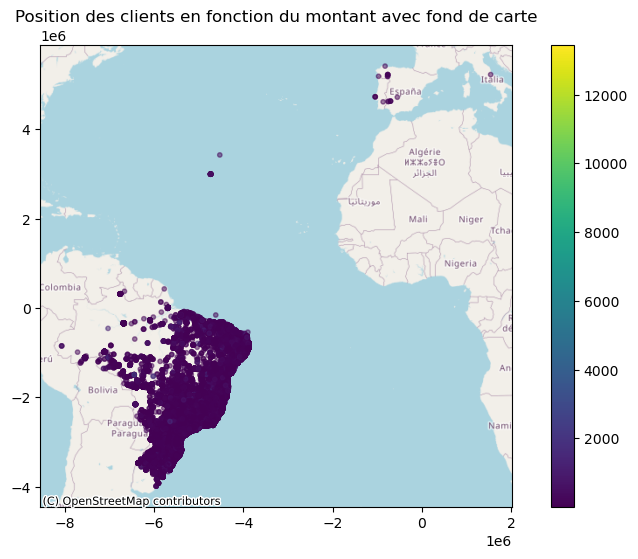

In [77]:
# Convertir en GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
    crs="EPSG:4326"
)

# Convertir vos données en GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["longitude"], data["latitude"]),
    crs="EPSG:4326"
)

# Reprojeter en Web Mercator (nécessaire pour les fonds de carte)
gdf = gdf.to_crs(epsg=3857)

# Définir l'étendue pour couvrir le monde entier
world_extent = [
    -20037508.34,  # Longitude minimale (en mètres, Web Mercator)
    -20037508.34,  # Latitude minimale
    20037508.34,   # Longitude maximale
    20037508.34    # Latitude maximale
]

# Tracer la carte avec un fond
# Tracer la carte avec des couleurs basées sur la consommation
ax = gdf.plot(
    column="montant",  # Colonne utilisée pour la couleur
    cmap="viridis",                  # Palette de couleurs (ex. 'viridis', 'plasma', 'coolwarm')
    legend=True,                     # Ajouter une légende pour comprendre les couleurs
    figsize=(10, 6),
    alpha=0.5,
    markersize=10                    # Taille des points
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Fond de carte OpenStreetMap
plt.title("Position des clients en fonction du montant avec fond de carte")
plt.show()

**Zoom sur le Brésil**

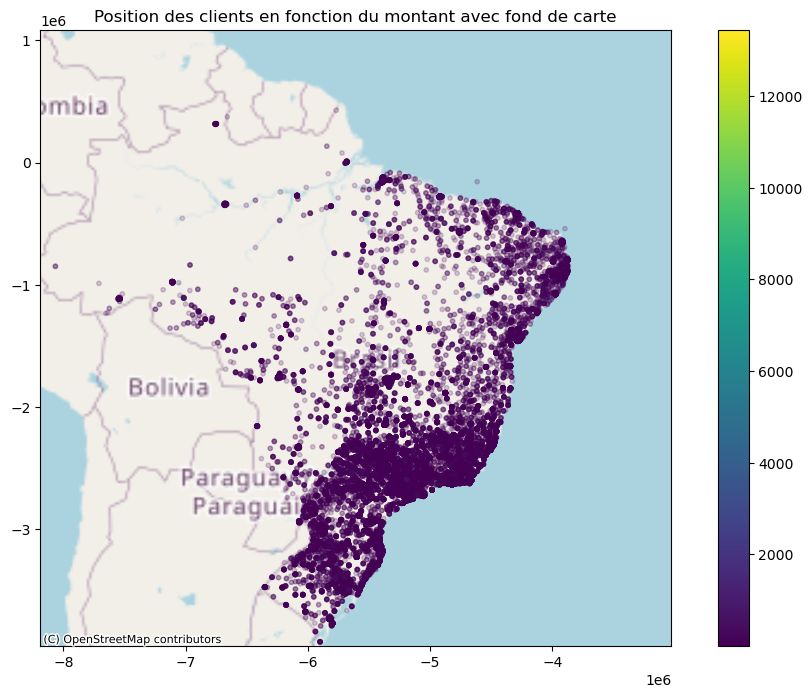

In [75]:
# Limites du Brésil en Web Mercator (approximation)
brazil_extent = [
    -8189898,  # Longitude minimale (en mètres)
    -3954361,  # Latitude minimale
    -3028275,  # Longitude maximale
    1084411    # Latitude maximale
]

# Tracer la carte avec un fond
# Tracer la carte avec des couleurs basées sur la consommation
ax = gdf.plot(
    column="montant",  # Colonne utilisée pour la couleur
    cmap="viridis",                  # Palette de couleurs (ex. 'viridis', 'plasma', 'coolwarm')
    legend=True,                     # Ajouter une légende pour comprendre les couleurs
    figsize=(12, 8),
    alpha=0.2,
    markersize=10                    # Taille des points
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Fond de carte OpenStreetMap

# Ajuster les limites pour zoomer sur le Brésil
ax.set_xlim(brazil_extent[0], brazil_extent[2])
ax.set_ylim(brazil_extent[1], brazil_extent[3])

plt.title("Position des clients en fonction du montant avec fond de carte")
plt.show()

**Zoom sur le Brésil en réduisant l'échelle des montants**

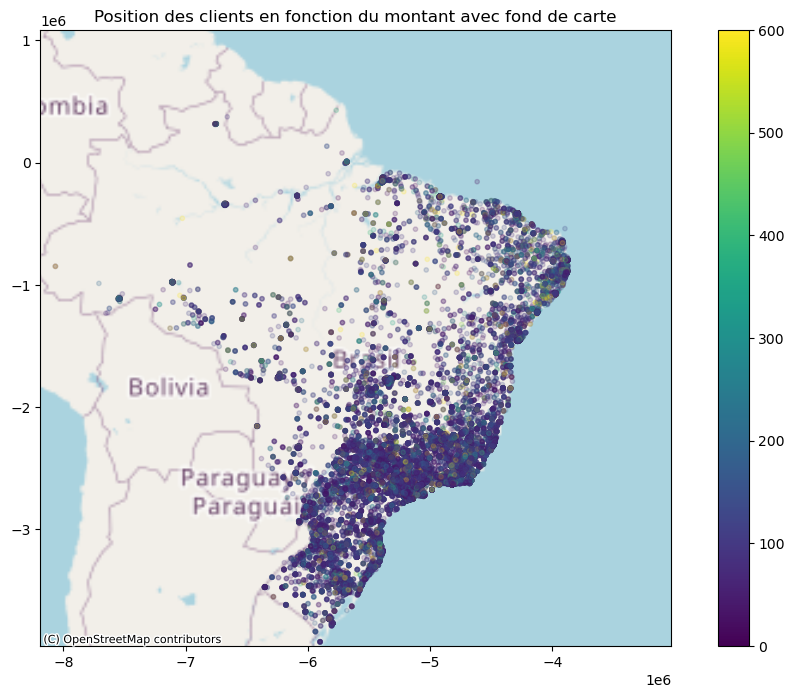

In [81]:
# Tracer la carte avec un fond
# Tracer la carte avec des couleurs basées sur la consommation
ax = gdf.plot(
    column="montant",  # Colonne utilisée pour la couleur
    cmap="viridis",                  # Palette de couleurs (ex. 'viridis', 'plasma', 'coolwarm')
    legend=True,                     # Ajouter une légende pour comprendre les couleurs
    figsize=(12, 8),
    alpha=0.2,
    markersize=10,                   # Taille des points
    vmin=0,                          # Limite minimale de l'échelle des couleurs
    vmax=600                        # Limite maximale de l'échelle des couleurs
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Fond de carte OpenStreetMap

# Ajuster les limites pour zoomer sur le Brésil
ax.set_xlim(brazil_extent[0], brazil_extent[2])
ax.set_ylim(brazil_extent[1], brazil_extent[3])

plt.title("Position des clients en fonction du montant avec fond de carte")
plt.show()

#### 2.2 - Distribution des variables

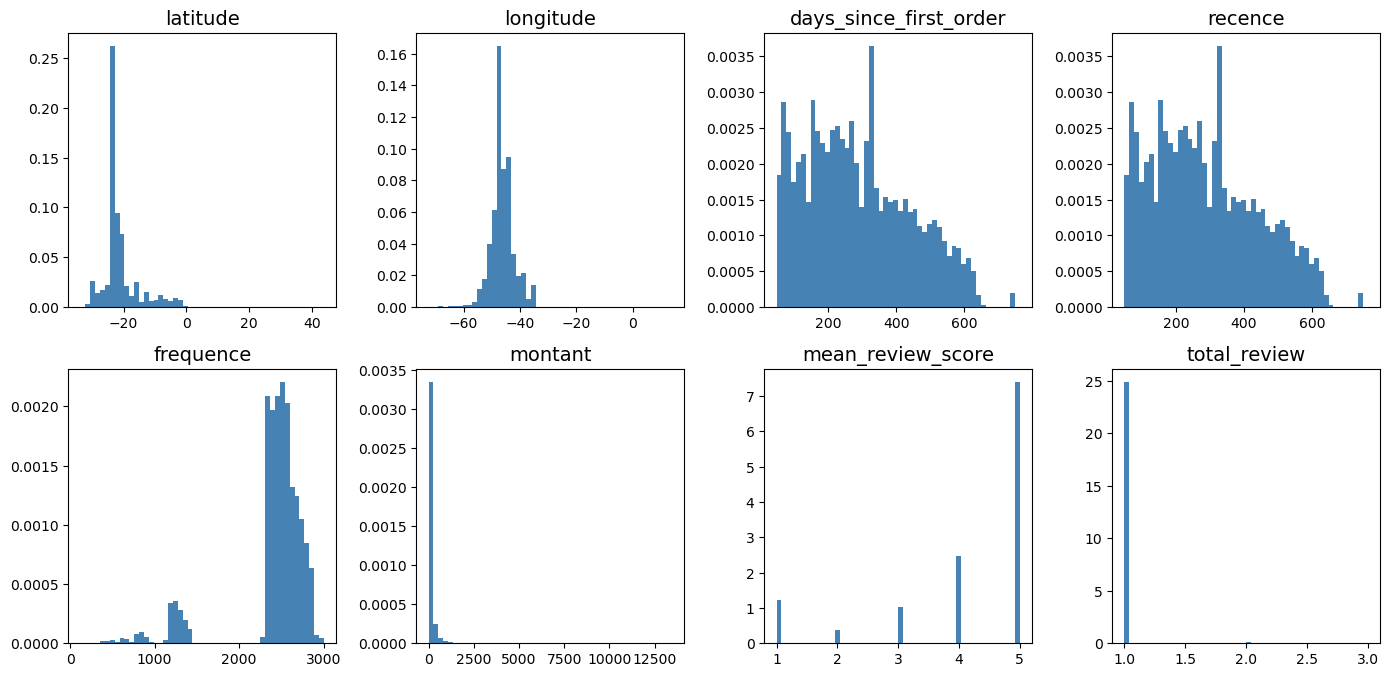

In [112]:
df = data.drop('customer_id', axis=1, inplace=False)

# Créer des histogrammes pour chaque colonne
fig = plt.figure(figsize=(14, 10))
for feat_idx in range(df.shape[1]):  # Pour chaque colonne
    ax = fig.add_subplot(3, 4, feat_idx + 1)  # Ajouter à la grille
    h = ax.hist(df.iloc[:, feat_idx], bins=50, color="steelblue", density=True, edgecolor="none")
    ax.set_title(df.columns[feat_idx], fontsize=14)

plt.tight_layout()
plt.show()

In [124]:
mask = df['total_review'] > 1
df.loc[mask, 'total_review']

76       2.0
318      2.0
389      2.0
806      2.0
1160     2.0
        ... 
95286    2.0
95458    2.0
95767    2.0
95955    2.0
96103    2.0
Name: total_review, Length: 522, dtype: float64

In [126]:
mask = df['total_review'] > 2
df.loc[mask, 'total_review']

15909    3.0
59486    3.0
65597    3.0
69199    3.0
Name: total_review, dtype: float64

In [128]:
mask = df['total_review'] > 4
df.loc[mask, 'total_review']

Series([], Name: total_review, dtype: float64)